# Bayesian optimized portfolio vs random investor

#### **Project Overview**  💪🏽
This project aims to **optimize a stock portfolio from the S&P 500** using **Bayesian Optimization** to maximize the **Sharpe Ratio**, a key measure of risk-adjusted returns. The objective is to determine the best allocation of stocks that balances **high returns with minimal risk**.

![MD Diagram](func.png)


### 1. Fetching Data 📈

In this step, we retrieve historical stock prices for 25 major S&P 500 companies using Yahoo Finance (yfinance). The data is collected for the past 12 months, with the first 6 months used for training and the last 6 months for testing.

To ensure data consistency, we handle missing values using forward and backward filling techniques. The final dataset includes adjusted closing prices, which are merged into a single DataFrame for further analysis and portfolio optimization.







In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import warnings
import matplotlib.pyplot as plt
import copy
from bayes_opt import BayesianOptimization


warnings.filterwarnings('ignore')

# ---------------------------
# 1. FETCH DATA
# ---------------------------
# Define date ranges
start_train = (datetime.today() - relativedelta(months=12)).strftime('%Y-%m-%d')
end_train   = (datetime.today() - relativedelta(months=6) - timedelta(days=1)).strftime('%Y-%m-%d')
start_test  = (datetime.today() - relativedelta(months=6)).strftime('%Y-%m-%d')
end_test    = (datetime.today() - timedelta(days=1)).strftime('%Y-%m-%d')

# Tickers (S&P 500 top picks)
tickers = [
    'AAPL', 'MSFT', 'AMZN', 'JPM', 'WMT', 'UNH', 'V', 'PG', 'JNJ',
    'HD', 'CVX', 'KO', 'CRM', 'CSCO', 'MCD', 'IBM', 'AXP', 'CAT',
    'VZ', 'DIS', 'GS', 'HON', 'BA', 'NKE', 'TRV'
]

print(f"Fetching stock data from {start_train} to {end_test} for {len(tickers)} tickers...\n")
final_data = pd.DataFrame()

for ticker in tickers:
    try:
        data = yf.download(ticker, start=start_train, end=end_test)
        data.reset_index(inplace=True)

        # Use Adjusted Close if available, else Close
        price_col = 'Adj Close' if 'Adj Close' in data.columns else 'Close'
        data = data[['Date', price_col]].rename(columns={price_col: ticker})

        # Merge into final_data
        if final_data.empty:
            final_data = data
        else:
            final_data = pd.merge(final_data, data, on='Date', how='outer')
    except Exception as e:
        print(f"Error fetching {ticker}: {str(e)}")

# Sort by date and forward/backward fill missing values
final_data.sort_values(by='Date', inplace=True)
final_data.fillna(method='ffill', inplace=True)
final_data.fillna(method='bfill', inplace=True)
final_data.reset_index(drop=True, inplace=True)

# ---------------------------
# 2. SPLIT INTO TRAIN & TEST
# ---------------------------
train_data = final_data[(final_data['Date'] >= start_train) & (final_data['Date'] <= end_train)].copy()
test_data  = final_data[(final_data['Date'] >= start_test)  & (final_data['Date'] <= end_test)].copy()

print("\nData fetching complete.")
print("Training Data Range:", train_data['Date'].iloc[0], "to", train_data['Date'].iloc[-1])
print("Test Data Range:    ", test_data['Date'].iloc[0],  "to", test_data['Date'].iloc[-1])

print("\n--- Training Data (first 5 rows) ---")
display(train_data.head())

print("\n--- Test Data (first 5 rows) ---")
display(test_data.head())


Fetching stock data from 2024-02-07 to 2025-02-06 for 25 tickers...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********


Data fetching complete.
Training Data Range: 2024-02-07 00:00:00 to 2024-08-06 00:00:00
Test Data Range:     2024-08-07 00:00:00 to 2025-02-05 00:00:00

--- Training Data (first 5 rows) ---


Price,Date,AAPL,MSFT,AMZN,JPM,WMT,UNH,V,PG,JNJ,...,IBM,AXP,CAT,VZ,DIS,GS,HON,BA,NKE,TRV
Ticker,,AAPL,MSFT,AMZN,JPM,WMT,UNH,V,PG,JNJ,...,IBM,AXP,CAT,VZ,DIS,GS,HON,BA,NKE,TRV
0,2024-02-07,188.486603,410.976715,170.529999,171.509293,55.791275,511.383423,277.270630,155.288467,153.131989,...,177.329544,206.787415,318.788727,37.862946,98.249374,377.515045,190.041763,211.919998,102.039635,210.392822
1,2024-02-08,187.401932,411.036316,169.839996,170.893387,55.787983,512.072571,274.198364,154.820023,151.600479,...,179.550049,208.894073,317.222351,37.385212,109.546959,375.933350,189.415161,209.220001,102.019966,209.990128
2,2024-02-09,188.169144,417.428497,174.449997,171.098679,55.758335,510.231354,274.844635,153.629410,151.949432,...,181.478394,210.140259,312.454163,37.207233,107.416275,375.171844,190.766281,209.199997,102.737663,210.667816
3,2024-02-12,186.475250,412.177795,172.339996,171.861237,56.094311,509.660370,273.492432,153.326859,153.005981,...,181.303101,209.932541,316.857819,37.563194,108.308189,383.353638,193.223831,209.330002,105.372467,210.854431
4,2024-02-13,184.372864,403.304138,168.639999,170.365448,55.712223,508.882507,274.228210,152.507095,151.668335,...,178.907288,207.370941,308.198242,37.591297,109.467674,369.792145,189.953629,204.460007,103.229225,212.091919



--- Test Data (first 5 rows) ---


Price,Date,AAPL,MSFT,AMZN,JPM,WMT,UNH,V,PG,JNJ,...,IBM,AXP,CAT,VZ,DIS,GS,HON,BA,NKE,TRV
Ticker,,AAPL,MSFT,AMZN,JPM,WMT,UNH,V,PG,JNJ,...,IBM,AXP,CAT,VZ,DIS,GS,HON,BA,NKE,TRV
125,2024-08-07,209.347107,396.918640,162.770004,198.156006,66.572327,561.924561,255.520828,168.001785,156.447693,...,183.732361,227.668427,323.447845,38.970318,85.580788,467.910095,195.878632,163.240005,71.930389,207.589340
126,2024-08-08,212.829224,401.162506,165.800003,201.775040,67.318542,562.083313,258.817932,168.841690,157.747345,...,189.446945,232.384964,333.733093,39.202515,85.580788,480.532501,197.759048,168.869995,73.485481,209.879684
127,2024-08-09,215.752640,404.479858,166.940002,203.495560,67.607071,554.658264,259.267090,168.515610,158.141159,...,189.952957,236.673660,335.817932,39.425037,85.829681,484.974121,196.185440,167.910004,73.634048,210.672882
128,2024-08-12,217.290939,405.266876,166.800003,203.881195,68.353294,561.140320,259.396851,164.829880,157.412582,...,187.998367,235.877625,333.604034,39.212189,85.570824,480.265442,194.760300,164.130005,73.931198,207.946274
129,2024-08-13,221.026825,412.439575,170.229996,205.611588,67.786163,570.024597,259.636383,165.304184,155.945572,...,189.496567,237.808029,336.354004,39.454060,85.222374,486.635986,194.700912,168.759995,77.754547,209.086502


### 2. Our Antagonist: the random investor 💰💰

To compare our optimized portfolio against a random investor, we create a randomly weighted portfolio on the first day of the test period. Random weights are assigned to each stock, ensuring they sum to 100% of the total capital ($100,000).

Using these weights, we calculate the dollar allocation for each stock and determine the number of shares that can be purchased at the first day's prices. Since stocks must be bought in whole units, we round down the number of shares and compute the leftover cash that remains uninvested. This serves as a benchmark for evaluating the performance of a data-driven investment strategy against pure randomness.

In [2]:
# ---------------------------
# 3. CREATE RANDOM PORTFOLIO ON TEST DAY 1
# ---------------------------
# Generate random weights
np.random.seed(42)  # For reproducibility
random_weights = np.random.random(len(tickers))
random_weights /= random_weights.sum()  # Normalize to sum=1

total_capital = 100000.0
dollar_allocation = random_weights * total_capital

# Day 1 prices of TEST data
first_day_prices = test_data.iloc[0][tickers]

# Calculate number of shares (floor to whole shares)
num_shares = (dollar_allocation / first_day_prices).apply(np.floor)

# Calculate leftover cash
leftover_cash_random = total_capital - (num_shares * first_day_prices).sum()
# print(f"\nLeftover cash (Random Portfolio): ${leftover_cash_random:,.2f}")


In this step, we calculate the **daily returns of the random portfolio during the test period**. First, we compute the percentage change in stock prices for each day. Then, we track how the total portfolio value evolves over time by multiplying the number of shares held with the daily stock prices and adding any leftover cash.

Finally, we calculate the daily portfolio returns as the percentage change in portfolio value. This allows us to analyze how the random investor's portfolio performs over time and compare it to the optimized portfolio.

In [3]:
# ---------------------------
# 4. CALCULATE DAILY RETURNS FOR TEST PERIOD
# ---------------------------
# Percent changes for test set
test_returns = test_data[tickers].pct_change().dropna()

# Track portfolio value day by day in TEST
portfolio_value = []
for idx in test_returns.index:
    # current prices for the same day
    prices_today = test_data.loc[idx, tickers]
    total_value_today = (num_shares.values * prices_today.values).sum() + leftover_cash_random
    portfolio_value.append(total_value_today)

portfolio_value = pd.Series(portfolio_value, index=test_returns.index, name='Portfolio Value')

# Portfolio daily returns (percentage) in the test set
portfolio_returns = portfolio_value.pct_change().dropna()

### 3. Evaluating Portfolio Performance ❓

- **Total Return** – The overall percentage gain or loss over the test period.  
- **Annualized Return** – The projected yearly return based on the test period's performance.  
- **Annualized Volatility** – A measure of risk, indicating the fluctuation in returns.  
- **Sharpe Ratio** – A key indicator of **risk-adjusted returns** (higher values are better).  
- **Max Drawdown** – The worst observed drop in portfolio value, measuring downside risk.  

**Methodology**  
- **Daily returns** are used to compute cumulative and annualized performance metrics.  
- **Risk-adjusted performance** is evaluated through volatility and Sharpe Ratio.  
- **Max drawdown** helps assess the worst-case downside scenario.  

By analyzing these metrics, we determine whether a **structured investment strategy** outperforms a **random approach** in both **returns and risk management**.


In [4]:
# ---------------------------
# 5. PERFORMANCE METRICS
# ---------------------------
def calculate_performance_metrics(returns_series, freq=252):
    """
    returns_series: Daily returns (e.g. 0.01 = 1%)
    freq: Trading days in a year (default=252).
    """
    # Total Return
    total_return = (1 + returns_series).prod() - 1

    # Annualized Return
    annualized_return = (1 + total_return)**(freq / len(returns_series)) - 1

    # Annualized Volatility
    annualized_volatility = returns_series.std() * np.sqrt(freq)

    # Sharpe Ratio (risk-free = 0)
    sharpe_ratio = (annualized_return / annualized_volatility) if annualized_volatility != 0 else np.nan

    # Max Drawdown
    cum_returns = (1 + returns_series).cumprod()
    running_max = cum_returns.cummax()
    drawdown    = (cum_returns - running_max) / running_max
    max_drawdown = drawdown.min()

    return {
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown
    }

metrics = calculate_performance_metrics(portfolio_returns)

### 4. Bayesian Optimization 😍
**Constraint serach for the best distribution over functions.**

![Optimization Diagram](bo_example.png)

### Interlude: Bayesian What? 
Bayesian Optimization is a strategy for optimizing **black-box functions** where evaluations are **expensive** and **computationally costly**. Unlike brute-force methods, it builds a **probabilistic model** of the function and **intelligently selects new points** to evaluate, balancing **exploration** (discovering new areas) and **exploitation** (focusing on promising regions).

1. **Gaussian Process**

A Gaussian Process is a probabilistic model that defines a distribution over possible functions. Instead of directly optimizing parameters, it learns from observations and maintains a belief (posterior) over all possible functions that could explain the data.

2. **Acquisition Function**

The acquisition function is a decision-making function that balances exploration (reducing uncertainty) and exploitation (sampling near the best-known values). The next sampling location is chosen by maximizing this function, guiding us toward optimal solutions.

3. **Observation, Update, Iteration**

At each step, we update our Gaussian Process model using Bayesian inference. The posterior distribution incorporates new observations, refining our belief about the unknown function. This allows us to iteratively improve our estimate of the function while quantifying uncertainty.

### Application in portfolio optimization

* We define a function that computes the Sharpe ratio for any given set of stock weights.
* The Bayesian optimizer then searches for the weight distribution that maximizes the Sharpe ratio.
* After a set number of iterations, **we extract the best portfolio weights** and validate their performance.

🚀 End result: We find the optimal stock weights that maximize returns while balancing risk (Sharpe ratio).


In [5]:
# ---------------------------
# 1. PREP TRAINING RETURNS
# ---------------------------
# Ensure 'train_data' has only the tickers' prices (no 'Date' column).
# Then compute daily returns:
train_returns = train_data[tickers].pct_change().dropna()

# ---------------------------
# 2. DEFINE THE OBJECTIVE FUNCTION
# ---------------------------
def portfolio_sharpe_ratio(**weights_dict):
    """
    Receives a dict of weights (one per ticker), normalizes them,
    then computes the Sharpe ratio for that allocation over the TRAINING SET.
    """
    raw_weights = np.array(list(weights_dict.values()))
    norm_weights = raw_weights / np.sum(raw_weights)
    # Compute daily portfolio returns by weighting each ticker's daily returns
    portfolio_daily_returns = (train_returns * norm_weights).sum(axis=1)
    # Calculate the Sharpe ratio via your performance metrics function
    metrics_local = calculate_performance_metrics(portfolio_daily_returns)
    return metrics_local['Sharpe Ratio']

# ---------------------------
# 3. BAYESIAN OPTIMIZATION SETUP
# ---------------------------
# Create a dict for each ticker's weight bounds, e.g. w0, w1, ...
pbounds = {f'w{i}': (0, 1) for i in range(len(tickers))}

# Create the Bayesian optimizer
optimizer = BayesianOptimization(
    f=portfolio_sharpe_ratio,
    pbounds=pbounds,
    random_state=42,  # for reproducibility
    verbose=2
)

# ---------------------------
# 4. ITERATIVE OPTIMIZATION WITH SNAPSHOTS
# ---------------------------
# Set the iterative optimization parameters:
INIT_POINTS = 5
N_ITER = 50
SNAPSHOT_ITERATIONS = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45]

# First, run a small random initialization.
optimizer.maximize(init_points=INIT_POINTS, n_iter=0)

# Initialize containers for convergence tracking and snapshots.
best_values = []
snapshots = {}

def record_state(iter_count):
    # Record the best Sharpe ratio seen so far
    if len(optimizer.space.target) > 0:
        best_val = np.max(optimizer.space.target)
    else:
        best_val = None
    best_values.append((iter_count, best_val))

    # If this iteration is in the snapshot list, store a deep copy of the optimizer.
    if iter_count in SNAPSHOT_ITERATIONS:
        snapshots[iter_count] = copy.deepcopy(optimizer)

# Record state after the initial random phase (iteration 0)
record_state(0)

# Now perform optimization one step at a time.
for i in range(1, N_ITER + 1):
    optimizer.maximize(init_points=0, n_iter=1)
    record_state(i)


|   iter    |  target   |    w0     |    w1     |    w10    |    w11    |    w12    |    w13    |    w14    |    w15    |    w16    |    w17    |    w18    |    w19    |    w2     |    w20    |    w21    |    w22    |    w23    |    w24    |    w3     |    w4     |    w5     |    w6     |    w7     |    w8     |    w9     |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.3395    | 0.3745    | 0.9507    | 0.732     | 0.5987    | 0.156     | 0.156     | 0.05808   | 0.8662    | 0.6011    | 0.7081    | 0.02058   | 0.9699    | 0.8324    | 0.2123    | 0.1818    | 0.1834    | 0.3042    | 0.5248    | 0.4319    | 0.2912    | 0.6119    | 0.1395    | 0.2921    | 0.3664    | 0.4561    |
| 2         | 0.1896  

### Visualizations ✨

**(A) Bayesian Optimization Convergence Plot**

Tracks the best Sharpe ratio found over successive iterations.
As iterations increase, the best Sharpe ratio should improve and eventually stabilize.


**(B) Partial Dependence Plot (1D Slice)**

The relationship between a single ticker's weight (e.g., AAPL) and the predicted Sharpe ratio.
The Gaussian Process (GP) model's mean prediction (blue line) and its uncertainty range (shaded area, 95% confidence).

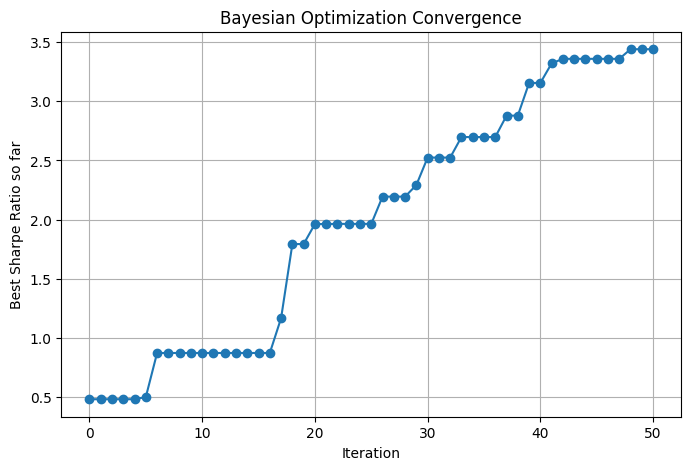

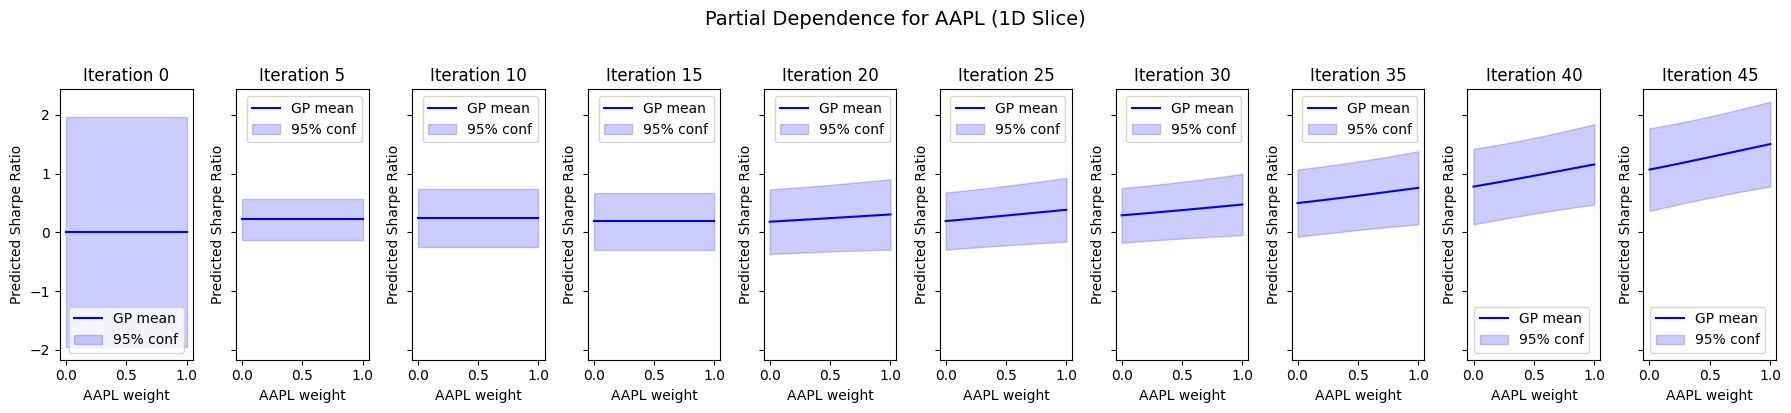

In [6]:
# ---------------------------
# 5. PLOTTING THE CONVERGENCE
# ---------------------------
iterations, sharpe_ratios = zip(*best_values)
plt.figure(figsize=(8, 5))
plt.plot(iterations, sharpe_ratios, marker='o')
plt.title("Bayesian Optimization Convergence")
plt.xlabel("Iteration")
plt.ylabel("Best Sharpe Ratio so far")
plt.grid(True)
plt.show()

# ---------------------------
# 6. PARTIAL DEPENDENCE PLOT (1D slice)
# ---------------------------
# Choose which ticker's weight to visualize
ticker_index = 0  # for example, 0 for the first ticker (e.g., 'AAPL')
n_points = 50     # number of points for sampling the selected ticker weight in [0,1]
w0_values = np.linspace(0, 1, n_points)

def partial_dependence(optimizer_snapshot, fixed_best_params, ticker_idx, w_values):
    """
    For each weight in w_values (for the selected ticker), build a complete weight vector that sums to 1.
    For j != ticker_idx, the other weights are adjusted proportionally based on fixed_best_params.
    Then, use the snapshot's Gaussian Process (GP) to predict the Sharpe ratio and uncertainty.
    """
    best_array = np.array([fixed_best_params[f'w{k}'] for k in range(len(tickers))])
    # Sum of weights for all tickers except the selected one.
    sum_except = best_array.sum() - best_array[ticker_idx]

    X = []
    for w in w_values:
        new_w = best_array.copy()
        # Set the selected ticker's weight to the new value.
        new_w[ticker_idx] = w
        # Scale the rest to sum to (1 - w)
        if sum_except > 0:
            scale_factor = (1.0 - w) / sum_except
        else:
            scale_factor = 0  # safeguard if the sum is zero
        for j in range(len(tickers)):
            if j != ticker_idx:
                new_w[j] = best_array[j] * scale_factor
        # Normalize to ensure the weights sum to 1 (just to be extra safe)
        new_w /= new_w.sum()
        X.append(new_w)

    X = np.array(X)  # shape: [len(w_values), n_tickers]

    # Predict using the snapshot's GP model.
    gp = optimizer_snapshot._gp  # GaussianProcessRegressor
    mu, sigma = gp.predict(X, return_std=True)

    return mu, sigma

# Create a subplot for each snapshot iteration.
fig, axes = plt.subplots(1, len(SNAPSHOT_ITERATIONS), figsize=(18, 4), sharey=True)

for ax, it in zip(axes, SNAPSHOT_ITERATIONS):
    snap_opt = snapshots.get(it)
    if snap_opt is None or len(snap_opt.space.target) == 0:

        ax.set_title(f"Iteration {it}: No Data")
        continue

    # Get the best parameter dict so far from the snapshot.
    best_point = snap_opt.max
    best_params = best_point["params"]  # keys: w0, w1, ...
    
    # Compute the partial dependence.
    mu_pred, sigma_pred = partial_dependence(
        optimizer_snapshot=snap_opt,
        fixed_best_params=best_params,
        ticker_idx=ticker_index,
        w_values=w0_values
    )
    
    # Plot the GP mean and 95% confidence interval.
    ax.plot(w0_values, mu_pred, 'b-', label='GP mean')
    ax.fill_between(
        w0_values,
        mu_pred - 1.96 * sigma_pred,
        mu_pred + 1.96 * sigma_pred,
        color='blue',
        alpha=0.2,
        label='95% conf'
    )
    ax.set_title(f"Iteration {it}")
    ax.set_xlabel(f"{tickers[ticker_index]} weight")
    ax.set_ylabel("Predicted Sharpe Ratio")
    ax.legend(loc='best')

plt.suptitle(f"Partial Dependence for {tickers[ticker_index]} (1D Slice)", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()



--- Random Portfolio vs Optimized Portfolio ---
Initial Random Portfolio Value:    $101,563.61
Final   Random Portfolio Value:    $118,022.81
Initial Optimized Portfolio Value: $101,601.45
Final   Optimized Portfolio Value: $123,490.09

Random Portfolio Metrics:
Total Return: 16.21%
Annualized Return: 36.03%
Annualized Volatility: 0.11
Sharpe Ratio: 334.51%
Max Drawdown: -0.06

Optimized Portfolio Metrics:
Total Return: 21.54%
Annualized Return: 49.14%
Annualized Volatility: 0.14
Sharpe Ratio: 347.04%
Max Drawdown: -0.10


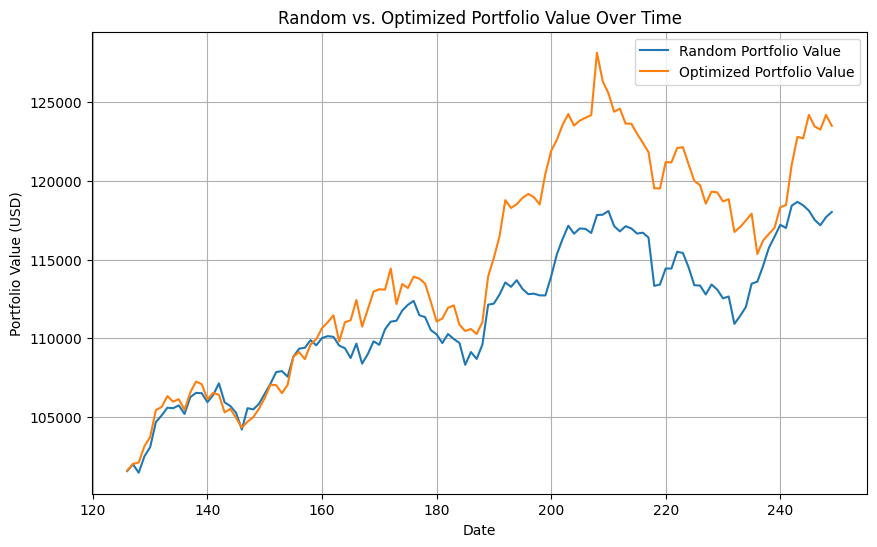


Optimized Portfolio Allocation:
AAPL: 0.2150
MSFT: 0.0000
AMZN: 0.0000
JPM: 0.0000
WMT: 0.2150
UNH: 0.0000
V: 0.0000
PG: 0.1401
JNJ: 0.0000
HD: 0.0000
CVX: 0.0000
KO: 0.2150
CRM: 0.0000
CSCO: 0.0000
MCD: 0.0000
IBM: 0.0000
AXP: 0.0000
CAT: 0.0000
VZ: 0.0000
DIS: 0.0000
GS: 0.2150
HON: 0.0000
BA: 0.0000
NKE: 0.0000
TRV: 0.0000


In [7]:
# ---------------------------
# 1) EXTRACT THE BEST RESULT FROM BAYESIAN OPTIMIZATION
# ---------------------------
best_result = optimizer.max
best_params = best_result['params']

# Convert the best_params dictionary to a normalized weight array
best_weights_raw = np.array([best_params[f'w{i}'] for i in range(len(tickers))])
best_weights = best_weights_raw / best_weights_raw.sum()

# ---------------------------
# 2) BUILD A DISCRETE-SHARE PORTFOLIO USING OPTIMIZED WEIGHTS
# ---------------------------
total_capital = 100000.0  # same capital as random portfolio

# first_day_prices is the price of each ticker on the first day of the test set
best_dollar_allocation = best_weights * total_capital
best_num_shares = (best_dollar_allocation / first_day_prices).apply(np.floor)

# leftover cash for optimized portfolio
leftover_cash_optimized = total_capital - (best_num_shares * first_day_prices).sum()

# ---------------------------
# 3) COMPUTE THE DAILY PORTFOLIO VALUE (TEST PERIOD)
# ---------------------------
best_portfolio_value = []
for idx in test_returns.index:
    prices_today = test_data.loc[idx, tickers]
    total_value_today = (best_num_shares.values * prices_today.values).sum() + leftover_cash_optimized
    best_portfolio_value.append(total_value_today)

best_portfolio_value = pd.Series(best_portfolio_value, index=test_returns.index, name='Optimized Value')

# ---------------------------
# 4) CONVERT TO DAILY RETURNS
# ---------------------------
best_portfolio_returns = best_portfolio_value.pct_change().dropna()

# ---------------------------
# 5) COMPARE METRICS
# ---------------------------
# 'portfolio_returns' is the daily returns for your random portfolio
# 'best_portfolio_returns' is for the optimized portfolio
random_metrics = calculate_performance_metrics(portfolio_returns)
optimized_metrics = calculate_performance_metrics(best_portfolio_returns)

print("\n--- Random Portfolio vs Optimized Portfolio ---")
print("Initial Random Portfolio Value:   ", f"${portfolio_value.iloc[0]:,.2f}")
print("Final   Random Portfolio Value:   ", f"${portfolio_value.iloc[-1]:,.2f}")
print("Initial Optimized Portfolio Value:", f"${best_portfolio_value.iloc[0]:,.2f}")
print("Final   Optimized Portfolio Value:", f"${best_portfolio_value.iloc[-1]:,.2f}")

print("\nRandom Portfolio Metrics:")
for k, v in random_metrics.items():
    if 'Return' in k or 'Ratio' in k:
        print(f"{k}: {v:.2%}")
    else:
        print(f"{k}: {v:.2f}")

print("\nOptimized Portfolio Metrics:")
for k, v in optimized_metrics.items():
    if 'Return' in k or 'Ratio' in k:
        print(f"{k}: {v:.2%}")
    else:
        print(f"{k}: {v:.2f}")

# ---------------------------
# 6) OPTIONAL: PLOT BOTH PORTFOLIO VALUE CURVES
# ---------------------------
plt.figure(figsize=(10,6))
plt.plot(portfolio_value, label="Random Portfolio Value")
plt.plot(best_portfolio_value, label="Optimized Portfolio Value")
plt.title("Random vs. Optimized Portfolio Value Over Time")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (USD)")
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------
# 7. PRINT FINAL PORTFOLIO
# ---------------------------
# Get the best weights from the optimizer
best_portfolio = optimizer.max

# Extract the weights
best_weights = best_portfolio['params']

# Normalize them to ensure they sum to 1
raw_weights = np.array(list(best_weights.values()))
normalized_weights = raw_weights / np.sum(raw_weights)

# Create a dictionary mapping tickers to their optimized weights
final_portfolio = {ticker: weight for ticker, weight in zip(tickers, normalized_weights)}

# Print the final optimized portfolio
print("\nOptimized Portfolio Allocation:")
for ticker, weight in final_portfolio.items():
    print(f"{ticker}: {weight:.4f}")


### **Main Limitations of the Current Bayesian Optimization Approach**  

#### **1️⃣ Model Complexity & Scalability**  
- **Issue:** Bayesian Optimization (BO) struggles with **high-dimensional spaces** (e.g., **25 stocks = 25 dimensions**).  
- **Why:** Gaussian Processes scale **poorly** with increasing dimensions due to **exponential growth in computation** and kernel complexity.  
- **Impact:** BO may become **inefficient**, requiring more evaluations and leading to **poor exploration** in large-dimensional spaces.  

✅ **Potential Fix:**  
- Use **dimensionality reduction** (e.g., PCA) to **project weights into a lower-dimensional space**.  
- Switch to **Trust Region-based Bayesian Optimization (TuRBO)** or **random embedding methods** that adaptively optimize in subspaces.  

---

#### **2️⃣ Limited Use of Prior Knowledge & Market Structure**  
- **Issue:** The optimization **treats all stocks equally**, ignoring known **market structures, sector correlations, or fundamental constraints**.  
- **Why:** We assume **independent priors** for each weight instead of integrating **domain knowledge** like factor models or risk constraints.  
- **Impact:** The model may **overfit short-term patterns** or **allocate unrealistic weights**.  

✅ **Potential Fix:**  
- **Incorporate prior knowledge** via a structured kernel (e.g., **multi-task GPs** to learn sector similarities).  
- **Use constraints** (e.g., max sector weight, risk parity) to **regularize allocation behavior**.  

---

#### **3️⃣ Lack of Dynamic or Adaptive Sampling Strategies**  
- **Issue:** The acquisition function **samples uniformly**, without considering whether certain regions are **more volatile or require finer exploration**.  
- **Why:** A naive BO approach **does not adaptively refine sampling based on portfolio sensitivity**.  
- **Impact:** Slower convergence; inefficient **exploration vs. exploitation** trade-off.  

✅ **Potential Fix:**  
- **Use adaptive acquisition functions** like Knowledge Gradient (KG) or Entropy Search (ES) to **focus on high-impact regions**.  
- Implement **Thompson Sampling**, which samples from the posterior GP, leading to **more diverse exploration**.  

---

#### **4️⃣ Handling of Portfolio Constraints & Regularization**  
- **Issue:** The approach **normalizes weights**, but does **not explicitly constrain for portfolio risk, turnover, or diversification**.  
- **Why:** The current BO framework only maximizes **Sharpe ratio**, ignoring **practical constraints like max drawdown or risk parity**.  
- **Impact:** Solutions may **not be robust** in real-world trading (e.g., over-concentrating in one stock).  

✅ **Potential Fix:**  
- Introduce **soft constraints** via penalized objectives (e.g., **L2 penalty on weight changes**).  
- Consider **multi-objective BO** to balance risk-return trade-offs.  

---

### **🚀 Key Takeaways & Next Steps**
✅ **Bayesian Optimization is effective** but **limited by scalability, lack of structure, and simplistic acquisition functions.**  
✅ **25D spaces are problematic**—reducing dimensionality or switching to adaptive BO could improve performance.  
✅ **Adding financial priors & constraints** would make the optimization more **realistic**.  
